<a href="https://colab.research.google.com/github/2SEHI/K-Digital_Lecture/blob/main/0820_pyTorch(LSTM%2C%20GRU%2C%20BERT)/pyTorch(LSTM_%EC%A3%BC%EA%B0%80%EB%B6%84%EC%84%9D).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM를 이용한 주가예측
- 과거의 데이터 패턴을 이용해서 미래의 데이터를 예측하는 것이라서 RNN을 이용하는 경우가 많습니다

## 공통 처리


### 1) 필요한 라이브러리 import

In [ ]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr

import matplotlib.pyplot as plt
import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

### 2) 데이터 가져오기

```
# 시작 날짜 설정
start = (년, 월, 일)

# *이 붙으면 collection의 데이터를 분할해서 대입
# start의 년월일이 쪼개서 들어감
start = datetime.datetime(*start)

# 종료 날짜를 생성
end = (년, 월, 일)
end = datetime.datetime(*end)

# 데이터 가져오기
df = pdr.DataReader('주식 코드', 'yahoo', start, end)

print(df.head())
```

#### ❗URL에러 날 경우 DataReader업그레이드 하기

In [ ]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

              High     Low    Open   Close      Volume    Adj Close
Date                                                               
2000-01-04  6110.0  5660.0  6000.0  6110.0  74195000.0  4719.226074
2000-01-05  6060.0  5520.0  5800.0  5580.0  74680000.0  4309.866211
2000-01-06  5780.0  5580.0  5750.0  5620.0  54390000.0  4340.761230
2000-01-07  5670.0  5360.0  5560.0  5540.0  40305000.0  4278.971680
2000-01-10  5770.0  5580.0  5600.0  5770.0  46880000.0  4456.618652


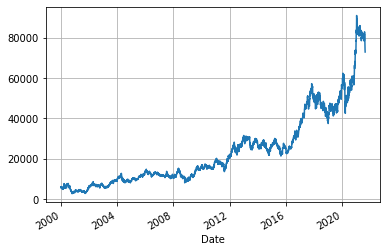

In [ ]:
year = 2000
month = 1
date = 1
# 시작 날짜 설정
start = (year, month, date)

# *이 붙으면 collection의 데이터를 분할해서 대입
# start의 년월일이 쪼개서 들어감
start = datetime.datetime(*start)

# 종료 날짜를 생성
end = (year, month, date)
# 오늘 날짜
end = datetime.date.today()

# 데이터 가져오기
df = pdr.DataReader('005930.KS', 'yahoo', start, end)

print(df.head())
df.Close.plot(grid=True)

### 3) 레이블 추출
- Volume을 타겟으로 지정

In [ ]:
X = df.drop(columns='Volume')
y = df.iloc[:, 3:4]

print(y)
print(type(y))

              Close
Date               
2000-01-04   6110.0
2000-01-05   5580.0
2000-01-06   5620.0
2000-01-07   5540.0
2000-01-10   5770.0
...             ...
2021-08-13  74400.0
2021-08-17  74200.0
2021-08-18  73900.0
2021-08-19  73100.0
2021-08-20  72700.0

[5433 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>


### 4) 데이터 정규화

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y)
print(y_mm)
print(X_ss.shape)

[[0.03829161]
 [0.0322873 ]
 [0.03274046]
 ...
 [0.8062762 ]
 [0.7972131 ]
 [0.79268155]]
(5433, 5)


### 5) 훈련 데이터와 테스트 데이터 분할

In [ ]:
X_train = X_ss[:4500, :]
X_test = X_ss[4500:, :]
y_train = y_mm[:4500, :]
y_test = y_mm[4500:, :]

In [ ]:
y_mm.shape

(5433, 1)

### 6) 데이터를 텐서로 변경

In [ ]:
# tensor로 변경
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

# 3차원으로 변경
X_train_tensors_final = torch.reshape(X_train_tensors,
                                      (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,
                                      (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print(X_train_tensors_final.shape, y_train_tensors.shape)
print(X_test_tensors_final.shape, y_test_tensors.shape)

torch.Size([5000, 1, 5]) torch.Size([5000, 1])
torch.Size([433, 1, 5]) torch.Size([433, 1])


### 7) 디바이스(GPU)설정

In [ ]:
if torch.cuda.is_available() :
    DEVICE = torch.device('cuda')
else :
    DEVICE = torch.device('cpu')
print('My Torch Version : ', torch.__version__, 'DEVICE : ', DEVICE)

My Torch Version :  1.9.0+cu102 DEVICE :  cuda


## LSTM모델


### 1) 모델 설계

In [ ]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers=num_layers, batch_first = True)
        
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        # 셀 상태에 히든 상태를 초기화
        # 0으로 채워진 tensor를 만듦(variable은 tensor) -> 초기화 함수를 만들지 않아도 됨
        # hidden
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(DEVICE)
        # cell상태
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(DEVICE)

        # 히든 상태에 셀 상태를 0으로 만들어서 대입
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

### 2) 하이퍼 파라미터 설정

In [ ]:
# 회귀이므로 더 많이 훈련
num_epochs = 30000
learning_rate = 0.00001

input_size = 5 # time_step, 수정할 경우 output의 size와 맞춰줘야 함(X_train_tensors_final)
hidden_size = 2 # 몇 개의 상태를 유지할 것인지 설정
num_layers = 1 # 은닉층을 몇개 쌓을 것인지

# 회귀는 결과가 무조건 1가지
# 분류의 경우 몇가지로 분류할지 적으면 됨
num_classes = 1 

In [ ]:
X_train_tensors_final.shape

torch.Size([5000, 1, 5])

### 3) 모델 생성 및 손실 함수와 최적화 함수 생성

In [ ]:
lstm = LSTM(num_classes, input_size, hidden_size, num_layers,X_train_tensors_final.shape[1]).to(DEVICE)

# 손실 함수
loss_function = torch.nn.MSELoss()
# 최적화 함수
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

### 4) 모델 훈련

In [ ]:
for epoch in range(num_epochs):
    outputs = lstm.forward(X_train_tensors_final.to(DEVICE))

    loss = loss_function(outputs, y_train_tensors.to(DEVICE))

    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d loss %1.5f" %(epoch, loss.item()))

Epoch: 0 loss 0.07940
Epoch: 100 loss 0.06853
Epoch: 200 loss 0.05738
Epoch: 300 loss 0.04789
Epoch: 400 loss 0.04016
Epoch: 500 loss 0.03411
Epoch: 600 loss 0.02961
Epoch: 700 loss 0.02652
Epoch: 800 loss 0.02468
Epoch: 900 loss 0.02392
Epoch: 1000 loss 0.02407
Epoch: 1100 loss 0.02493
Epoch: 1200 loss 0.02630
Epoch: 1300 loss 0.02799
Epoch: 1400 loss 0.02984
Epoch: 1500 loss 0.03167
Epoch: 1600 loss 0.03335
Epoch: 1700 loss 0.03476
Epoch: 1800 loss 0.03578
Epoch: 1900 loss 0.03630
Epoch: 2000 loss 0.03621
Epoch: 2100 loss 0.03542
Epoch: 2200 loss 0.03391
Epoch: 2300 loss 0.03172
Epoch: 2400 loss 0.02899
Epoch: 2500 loss 0.02594
Epoch: 2600 loss 0.02283
Epoch: 2700 loss 0.01990
Epoch: 2800 loss 0.01738
Epoch: 2900 loss 0.01540
Epoch: 3000 loss 0.01406
Epoch: 3100 loss 0.01334
Epoch: 3200 loss 0.01323
Epoch: 3300 loss 0.01362
Epoch: 3400 loss 0.01442
Epoch: 3500 loss 0.01549
Epoch: 3600 loss 0.01667
Epoch: 3700 loss 0.01782
Epoch: 3800 loss 0.01879
Epoch: 3900 loss 0.01942
Epoch: 4000 

### 5) 예측하기

#### 예측에 사용할 데이터 만들기

In [ ]:
df_X_ss = ss.fit_transform(df.drop(columns = 'Volume'))
df_y_mm = mm.fit_transform(df.iloc[:, 5:6])

df_X_ss = Variable(torch.Tensor(df_X_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))

df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

#### 예측

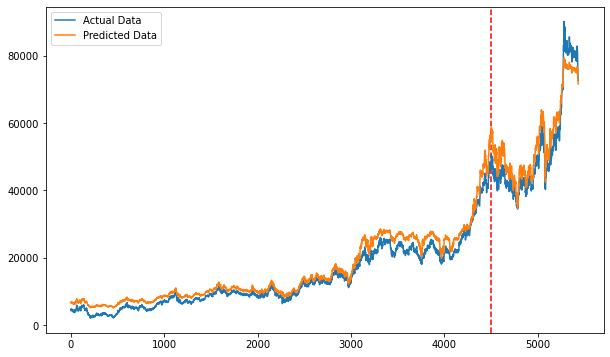

In [ ]:
# 예측
train_predict = lstm(df_X_ss.to(DEVICE))
# 예측한 결과가 tensor이므로 numpy로 변환
data_predict = train_predict.data.detach().cpu().numpy()
dataY_plot = df_y_mm.data.numpy()

# 정규화된 데이터를 복원
data_predict = mm.inverse_transform(data_predict)
dataY_plot = mm.inverse_transform(dataY_plot)

# 훈련에 사용한 데이터의 결과를 그래프로 그리기
plt.figure(figsize=(10, 6))
plt.axvline(x=4500, c='r', linestyle='--')

plt.plot(dataY_plot, label='Actual Data')
plt.plot(data_predict, label='Predicted Data')

plt.legend()
plt.show()

attentionmask = 데이터가 있는 부분에만 1.0으로 하여 그부분만 학습 학습속도를 빠르게 함

감성분석이기 때문에 2로 분류